<a href="https://colab.research.google.com/github/amit653/EnsembleTechniques/blob/master/cnnweek1mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: ignored

In [1]:

#configuration for memory management
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    #### When GPU is found in current running environment ####
     try:
     # Currently, memory growth needs to be the same across GPUs
         for gpu in gpus:
             tf.config.experimental.set_memory_growth(gpu, True)
             logical_gpus = tf.config.experimental.list_logical_devices('GPU')
             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
     except RuntimeError as e:

     # Memory growth must be set before GPUs have been initialized
         print(e)



NameError: ignored

In [11]:
import numpy as np
from PIL import Image
#data = np.load('images.npy',allow_pickle=True)
#data = np.load('/content/drive/My Drive/DLCP/Project-2/images.npy')
data = np.load('/content/drive/My Drive/DLCP/Project-2/images.npy',allow_pickle=True)
print (data.shape)  # (409,2)
print (data.dtype)
#print (img_array)


(409, 2)
object


(409, 2)
<class 'numpy.ndarray'>
818
[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


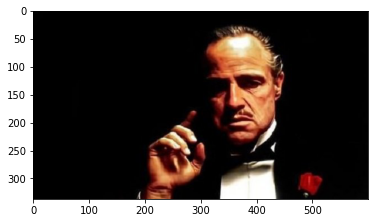

In [12]:
#Importing required librarires
import csv
import math
import cv2

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

from matplotlib import pyplot as plt
print(data.shape)
print(type(data))
print(data.imag.size)
#print(data[0].shape)
#print(data.imag[0])
print (data[10, 1]) # dictionary points 
#print (data[10, 0]) # actual image 
#visulaizing the loaded data
plt.imshow(data[10,0])
plt.show()

In [0]:
# setting up all the required hyperparameters
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

EPOCHS = 50
BATCH_SIZE = 4
PATIENCE = 10

THREADS = 1

(409,)


In [0]:
#Create features and labels¶
#preprocessing the input images and the masks
print(data.shape[0])
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(409, 224, 224, 3)
(409, 224, 224)


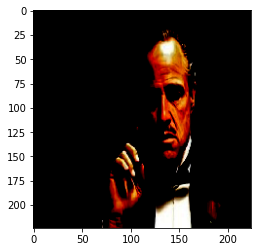

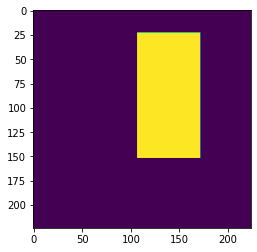

In [0]:
#Print the shape of X_train and mask array (1 mark)
print (X_train.shape) #we have 409 images of size 224 x 224 and with 3 channels (RGB)
print(masks.shape )#we have 409 masks of size 224 x 224

#Print a sample image and image array
from matplotlib import pyplot
plt.imshow(X_train[10])
plt.show()
plt.imshow(masks[10])
plt.show()

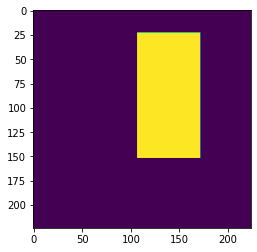

In [0]:
print("image array :", X_train[0]) # print image array




In [0]:
# resizing the masks to 28 * 28 for faster implementation of the model
masks_resized = np.zeros((int(data.shape[0]), 28, 28))
for mask_len in range(masks.shape[0]):
 masks_resized[mask_len] = cv2.resize(masks[mask_len], (28,28))
print (masks.shape, masks_resized.shape)

(409, 224, 224) (409, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


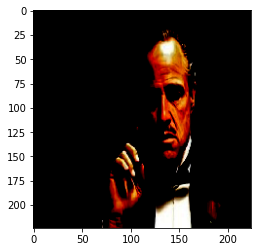

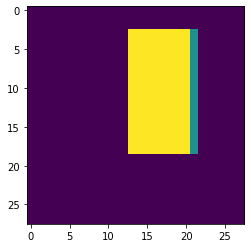

In [0]:
plt.imshow(X_train[10])
plt.show()
plt.imshow(masks_resized[10])
plt.show()

In [0]:
'''
Create the model (10 marks)

    Add MobileNet as model with below parameter values
        input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
        include_top: False
        alpha: 1.0
        weights: "imagenet"
    Add UNET architecture layers
        This is the trickiest part of the project, you need to research and implement it correctly
'''
def create_model(trainable=True):
    #using transposed learning , using mobilenet architecture with the weights of imagenet
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

        #Unet architecture implementation
        #from mobilenet the pointwise layers are chosen , upsampled and concantenated with the layer before downsampling
    block1 = model.get_layer("conv_pw_5_relu").output #28 *28 layer before downsampling to 14 *14
    block2 = model.get_layer("conv_pw_11_relu").output #14 *14 layer before downsampling to 7 *7
    block3 = model.get_layer("conv_pw_13_relu").output #7 *7 layer 

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x) #final activation function
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x) #reshaping output to 28 * 28

    return Model(inputs=model.input, outputs=x)

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())


In [0]:
model = create_model(False)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112

In [0]:
#Define checkpoint and earlystopping
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(False)
#model.summary()
    

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

In [0]:
#Define checkpoint and earlystopping
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [0]:
#print(X_train)
#print( masks_resized)

In [0]:
#Train-test data split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, masks_resized, test_size=0.30, random_state=1)

In [0]:
#Compile the model (5 marks)
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [0]:
#fit the model
model.fit(x=X_train,
 y=y_train,
 epochs=EPOCHS,
 callbacks=[checkpoint, reduce_lr, stop],
 batch_size = BATCH_SIZE,
 validation_data=(X_val, y_val), verbose=1
 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 286 samples, validate on 123 samples
Epoch 1/50
284/286 [============================>.] - ETA: 0s - loss: 2.3040 - dice_coefficient: 0.2154
Epoch 00001: loss improved from inf to 2.29988, saving model to model-2.30.h5
286/286 [==============================] - 39s 136ms/sample - loss: 2.2999 - dice_coefficient: 0.2171 - val_loss: 1.9209 - val_dice_coefficient: 0.2552
Epoch 2/50
284/286 [============================>.] - ETA: 0s - loss: 1.8164 - dice_coefficient: 0.2779
Epoch 00002: loss improved from 2.29988 to 1.82128, saving model to model-1.82.h5
286/286 [==============================] - 35s 124ms/sample - loss: 1.8213 - dice_coefficient: 0.2758 - val_loss: 1.5875 - val_dice_coefficient: 0.3205
Epoch 3/50
284/286 [============================>.] - ETA: 0s - loss: 1.5566 - dice_coefficient: 0.3300
Epoch 00003: loss improved from 1.82128 to 1.55946, saving model to model-1.56.h5
28

In [0]:
#Get the predicted mask for a sample image (5 marks)
predicted_mask = model.predict(X_train)



In [0]:
def impose_mask_3Dimage(X, mask):
 
 resized_mask = cv2.resize(mask, (X.shape[0], X.shape[1]), 1)#resizing the mask to the input image size
 mask_rgb = np.zeros_like(X)
 ### imposing mask on each channel ###
 for i in range(3):
     mask_rgb[:,:,i] = X[:,:,i] * resized_mask #wherever mask is one ,copy the input image value
 return mask_rgb

In [0]:
def plot_images(index , X , preicted_mask):
    print("Original image")
    plt.imshow(X[index])
    plt.show()
    print("Original mask")
    plt.imshow(masks[index])
    plt.show()
    print("Predicted mask")
    plt.imshow(predicted_mask[index])
    plt.show()
    print("Predicted mask imposed on original image")
    plt.imshow(impose_mask_3Dimage(X[index], predicted_mask[index]))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image


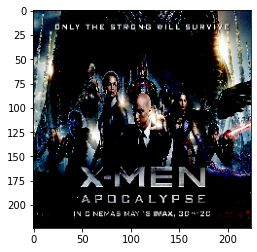

Original mask


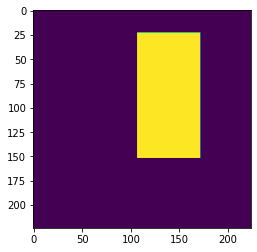

Predicted mask


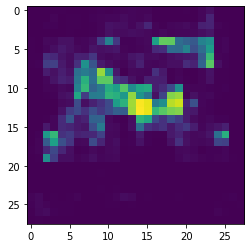

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted mask imposed on original image


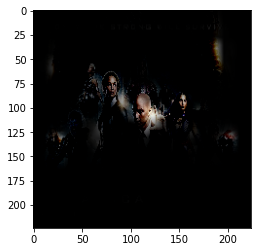

'\nConclusion\n\n    we have implemented the Unet layers on top of mobilenet architecture.\n    loss: 0.7463 - dice_coefficient: 0.6083 - val_loss: 0.8329 - val_dice_coefficient: 0.5881\n    Training accuracy is good but the validation accuracy is not great\n    Further, the model should be improved with deeper unet (more contraction and less expansion)\n    On further reading , we find out the models such as UNet++ have improved accuracy and also one more paper suggests that use of dilated convulation layers improve the accuracy.\n'

In [47]:
#Impose the mask on the image (5 marks)
plot_images(10,X_train,predicted_mask)

'''
Conclusion

    we have implemented the Unet layers on top of mobilenet architecture.
    loss: 0.7463 - dice_coefficient: 0.6083 - val_loss: 0.8329 - val_dice_coefficient: 0.5881
    Training accuracy is good but the validation accuracy is not great
    Further, the model should be improved with deeper unet (more contraction and less expansion)
    On further reading , we find out the models such as UNet++ have improved accuracy and also one more paper suggests that use of dilated convulation layers improve the accuracy.
'''
